In [124]:
from pymutspec import draw
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, wilcoxon, mannwhitneyu, f_oneway, zscore

# Swap that to True if you want to invert nucls
INVERT = False
#Change to true to filter mutspecs by num of total muts and num of mut types
FILTER = True
PATH_TO_12MUTSPEC = '/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/AllInsects/midori_all_insects_mutspec/ms12syn_internal_iqtree.tsv'
PATH_TO_192MUTSPEC = '/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/AllInsects/midori_all_insects_mutspec/ms192syn_internal_iqtree.tsv'
PATH_TO_METADATA = '/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/AllInsects/midori_all_insects_mutspec/msMetaData.tsv'
PATH_TO_CODONTABLE = '/mnt/data/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/DescriptiveStat/codontable_midori_Blattodea.csv'

In [125]:
mutspec12 = pd.read_csv(PATH_TO_12MUTSPEC, sep='\t')
mutspec192 = pd.read_csv(PATH_TO_192MUTSPEC, sep='\t')

In [126]:

if INVERT == True:
    # inverts nucls for ms12, needs to be run only once. DO NOT FUCKING DO IT! Now we stick to original mutspec (with higher T>C rather than A>G)
    a_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'A>G'], mutspec12[mutspec12['Mut'] == 'A>C'], mutspec12[mutspec12['Mut'] == 'A>T']])
    t_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'T>G'], mutspec12[mutspec12['Mut'] == 'T>C'], mutspec12[mutspec12['Mut'] == 'T>A']])
    g_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'G>T'], mutspec12[mutspec12['Mut'] == 'G>C'], mutspec12[mutspec12['Mut'] == 'G>A']])
    c_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'C>T'], mutspec12[mutspec12['Mut'] == 'C>G'], mutspec12[mutspec12['Mut'] == 'C>A']])

    a_spec.loc[a_spec['Mut'] == 'A>G', 'Mut'] = 'T>C'
    a_spec.loc[a_spec['Mut'] == 'A>C', 'Mut'] = 'T>G'
    a_spec.loc[a_spec['Mut'] == 'A>T', 'Mut'] = 'T>A'

    t_spec.loc[t_spec['Mut'] == 'T>G', 'Mut'] = 'A>C'
    t_spec.loc[t_spec['Mut'] == 'T>C', 'Mut'] = 'A>G'
    t_spec.loc[t_spec['Mut'] == 'T>A', 'Mut'] = 'A>T'

    g_spec.loc[g_spec['Mut'] == 'G>T', 'Mut'] = 'C>A'
    g_spec.loc[g_spec['Mut'] == 'G>C', 'Mut'] = 'C>G'
    g_spec.loc[g_spec['Mut'] == 'G>A', 'Mut'] = 'C>T'

    c_spec.loc[c_spec['Mut'] == 'C>T', 'Mut'] = 'G>A'
    c_spec.loc[c_spec['Mut'] == 'C>G', 'Mut'] = 'G>C'
    c_spec.loc[c_spec['Mut'] == 'C>A', 'Mut'] = 'G>T'

    mutspec12 = pd.concat([a_spec, t_spec, g_spec, c_spec]).sort_values(by=['Species', 'Mut'])

In [127]:
###DO NOT RUN! See bellow (although filtration might be usefull, we'll see)
###THIS IS ALL FOR R, PLS IGNORE IT, RUN ONLY WHEN cocks_phylo_stats.r NEEDS NEW FILTERED MUTSPEC
mutspec12 = mutspec12.sort_values(['Species', 'Mut'])
meta_df = pd.read_csv(PATH_TO_METADATA, sep='\t').sort_values(by='Species')


def chop(l, chunk_size):
    for i in range(0, len(l), chunk_size):
        yield l[i:i + chunk_size]

if FILTER == True:
    #removing species with less than 15 total mutations
    mut_ammount_df = mutspec12.groupby(mutspec12['Species']).aggregate({'ObsNum' : 'sum'}).reset_index()
    less_than_15_total_muts = mut_ammount_df.drop(mut_ammount_df[mut_ammount_df['ObsNum'] > 15].index)['Species'].to_list()
    for sp in less_than_15_total_muts:
        mutspec12 = mutspec12.drop(mutspec12[mutspec12['Species'] == sp].index)
        meta_df = meta_df.drop(meta_df[meta_df['Species'] == sp].index)
    
    #removing species with less than 4 mutation types
    species = mutspec12['Species'].drop_duplicates().to_list()
    obsnum_values = mutspec12['ObsNum'].to_list()
    chopped_obsnum =  list(chop(obsnum_values, 12))
    
    species_and_obsnum = {}
    for i in range(len(species)):
        species_and_obsnum[species[i]] = chopped_obsnum[i]
    
    less_than_4_mut_types = []
    for sp, obsnum_list in species_and_obsnum.items():
        if obsnum_list.count(0) > 8:
            less_than_4_mut_types.append(sp)
    
    for sp in less_than_4_mut_types:
        mutspec12 = mutspec12.drop(mutspec12[mutspec12['Species'] == sp].index)
        meta_df = meta_df.drop(meta_df[meta_df['Species'] == sp].index)
    
#half-assed way of converting the table into what I need
mutspec_vals = mutspec12['MutSpec'].to_list()
muts = mutspec12['Mut'].to_list()[0:12]
species = mutspec12['Species'].drop_duplicates().to_list() #need to reset after removing species

chopped_values = list(chop(mutspec_vals, 12))
df_prep = {}
for i in range(len(species)):
    df_prep[species[i]] = chopped_values[i]
df = pd.DataFrame(df_prep)
df = df.T
df.columns = muts
df = df.fillna(0)
df.to_csv("/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/AllInsects/midori_all_insects_mutspec/mutspec_as_header_12internal.csv")

In [128]:
mutspec12 = mutspec12.dropna()
mutspec192 = mutspec192.dropna()

# ALL MUTSPECS

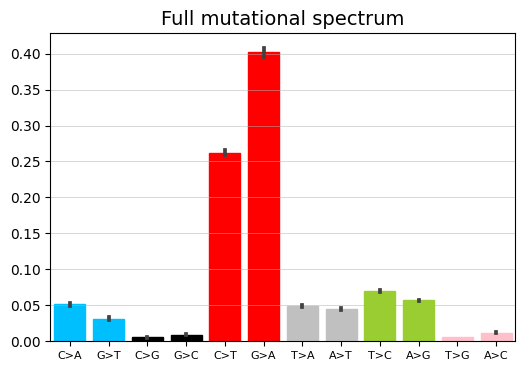

<AxesSubplot:title={'center':'Full mutational spectrum'}>

In [129]:
draw.plot_mutspec12(mutspec12, savepath='/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/figures/midori_all_insects_mutspec/mutspec12.pdf')

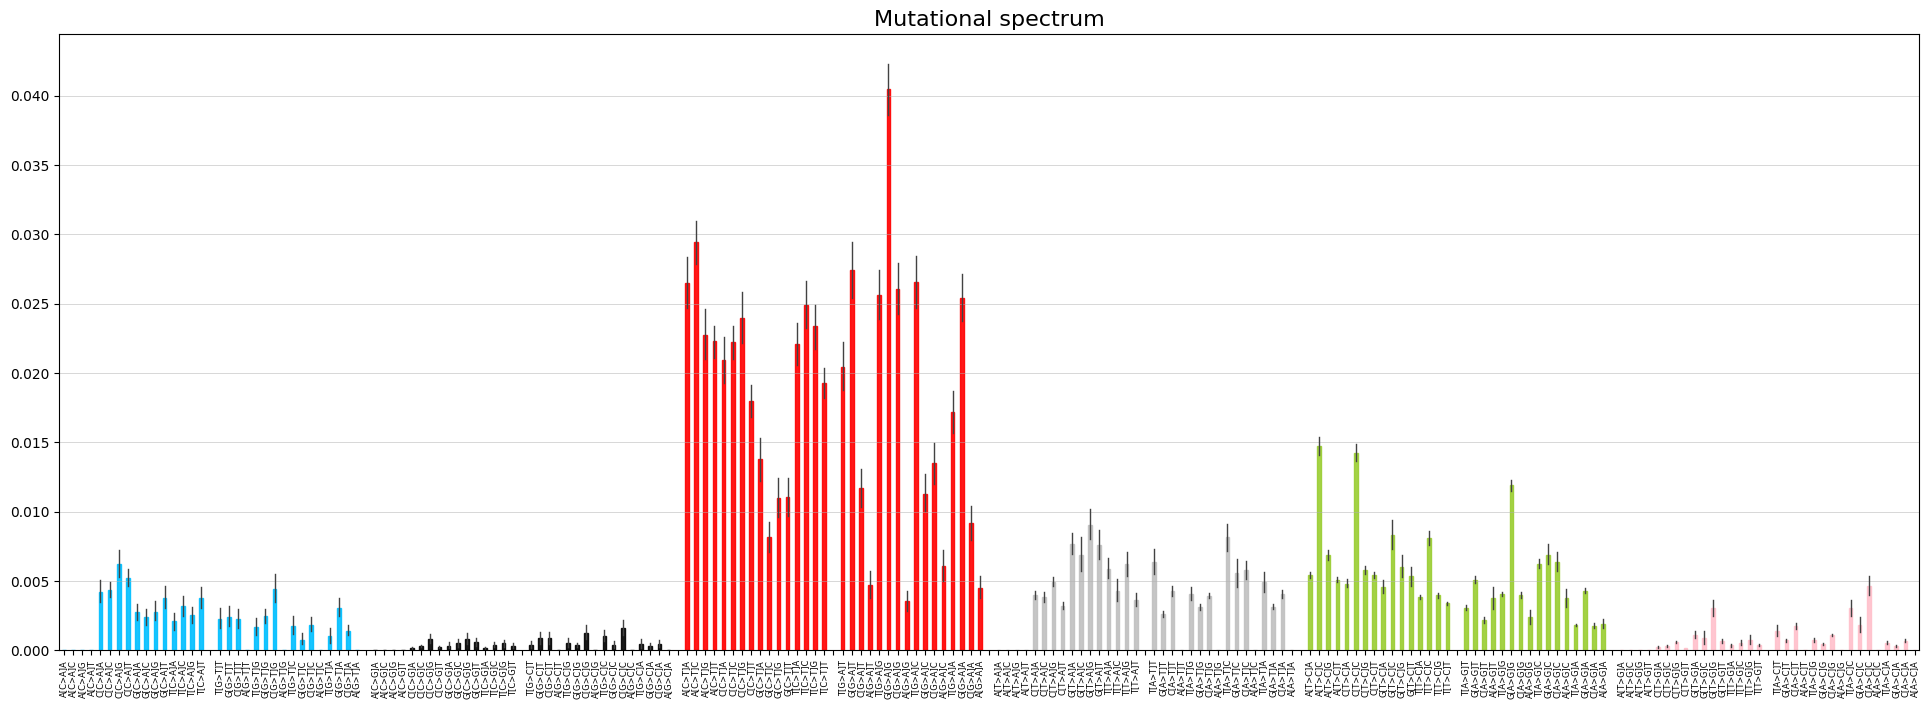

<AxesSubplot:title={'center':'Mutational spectrum'}>

In [130]:
draw.plot_mutspec192(mutspec192, savepath='/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/figures/midori_all_insects_mutspec/mutspec192.pdf')

# Search for outliers

In [131]:
#half-assed way of converting the table into what I need
mutspec_vals = mutspec12['MutSpec'].to_list()
muts = mutspec12['Mut'].to_list()[0:12]
species = mutspec12['Species'].drop_duplicates().to_list() #need to reset after removing species

chopped_values = list(chop(mutspec_vals, 12))
df_prep = {}
for i in range(len(species)):
    df_prep[species[i]] = chopped_values[i]
df = pd.DataFrame(df_prep)
df = df.T
df.columns = muts
df = df.fillna(0)

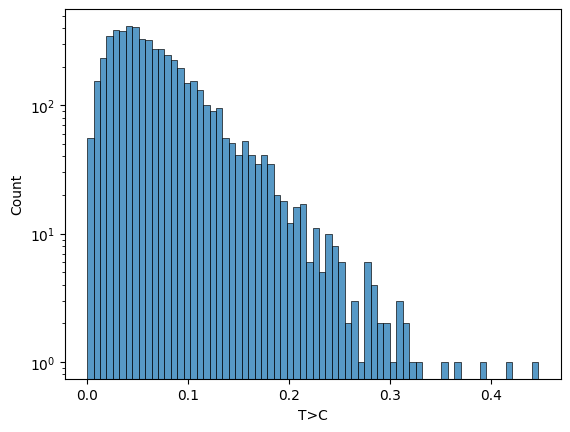

In [132]:
if INVERT == True:
    outlier_spec = df.drop(columns=['A>C', 'A>T', 'C>A', 'C>G', 'C>T', 'G>A', 'G>C', 'G>T', 'T>A', 'T>C', 'T>G'])
    sns.histplot(outlier_spec, x='A>G')
    plt.yscale('log')
else:
    outlier_spec = df.drop(columns=['A>G', 'A>C', 'A>T', 'C>A', 'C>T', 'C>G', 'G>A', 'G>C', 'G>T', 'T>A', 'T>G'])
    sns.histplot(outlier_spec, x='T>C')
    plt.yscale('log')

In [133]:
#getting top 5 smallest and largest values
def get_top5(mut, mutspec):
    top_5_small = mutspec[mut].nsmallest(n=round(len(mutspec) * 0.05))
    top_5_large = mutspec[mut].nlargest(n=round(len(mutspec) * 0.05))
    top_5_meta = meta_df
    top5s5l = pd.concat([top_5_small, top_5_large])

    top5 = []
    for sp in top5s5l.index:
        top5.append(top_5_meta[top_5_meta['Species'] == sp])
    top_5_meta = pd.concat(top5)
    top5s5l = top5s5l.sort_index()
    top_5_meta = top_5_meta.sort_values(by=['Species'])
    top_5_meta = top_5_meta.reset_index().drop(columns=['index'])
    top5s5l = top5s5l.reset_index().drop(columns=['index'])
    top_5_meta = pd.concat([top_5_meta, top5s5l[mut]], axis=1)
    top_5_meta = top_5_meta.sort_values(by=[mut], ascending=False)

    top_5_meta.to_csv(f'/mnt/data/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/AllInsects/midori_all_insects_mutspec/ms12syn_internal_{mut}_top5largesmall.tsv', sep='\t', index=False)
    print(top_5_meta)

if INVERT == True:
    get_top5('A>G', outlier_spec)
else:
    get_top5('T>C', outlier_spec)


                         Species          Class             Order  \
326             Machimus_notatus  Insecta_50557      Diptera_7147   
529  Trinervitermes_occidentalis  Insecta_50557   Blattodea_85823   
31             Andrena_ventralis  Insecta_50557  Hymenoptera_7399   
499           Strumigenys_rogeri  Insecta_50557  Hymenoptera_7399   
289       Hypotermes_makhamensis  Insecta_50557   Blattodea_85823   
..                           ...            ...               ...   
171          Cotesia_melitaearum  Insecta_50557  Hymenoptera_7399   
160     Coleophora_glaucicolella  Insecta_50557  Lepidoptera_7088   
453      Psilocorsis_quercicella  Insecta_50557  Lepidoptera_7088   
344             Metacnephia_lyra  Insecta_50557      Diptera_7147   
121              Ceratina_cyanea  Insecta_50557  Hymenoptera_7399   

                     Family                 Genus  Nodes_in_tree       T>C  
326          Asilidae_50673       Machimus_247604           17.0  0.447058  
529        Termit

In [134]:
#gettin statistical outliers. In this case it's only highest values
def get_stat_outliers(mut, mutspec, meta):
    mut_outliers = mutspec[(np.abs(zscore(mutspec)) > 3).all(axis=1)]
    outliers = []
    for sp in mut_outliers.index:
        outliers.append(meta[meta['Species'] == sp])
    meta = pd.concat(outliers)

    mut_outliers = mut_outliers.sort_index()
    meta = meta.sort_values(by=['Species'])
    meta = meta.reset_index().drop(columns=['index'])
    mut_outliers = mut_outliers.reset_index().drop(columns=['index'])
    meta = pd.concat([meta, mut_outliers[mut]], axis=1)
    meta = meta.sort_values(by=[mut], ascending=False)

    meta.to_csv(f'/mnt/data/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/AllInsects/midori_all_insects_mutspec/ms12syn_internal_{mut}outliers.tsv', sep='\t', index=False)
    print(meta)


if INVERT == True:
    get_stat_outliers('A>G', outlier_spec, meta_df)
else:
    get_stat_outliers('T>C', outlier_spec, meta_df)

                        Species          Class             Order  \
46             Machimus_notatus  Insecta_50557      Diptera_7147   
75  Trinervitermes_occidentalis  Insecta_50557   Blattodea_85823   
10            Andrena_ventralis  Insecta_50557  Hymenoptera_7399   
69           Strumigenys_rogeri  Insecta_50557  Hymenoptera_7399   
38       Hypotermes_makhamensis  Insecta_50557   Blattodea_85823   
..                          ...            ...               ...   
45          Macaria_aemulataria  Insecta_50557  Lepidoptera_7088   
64            Schizura_ipomoeae  Insecta_50557  Lepidoptera_7088   
32              Erebia_aethiops  Insecta_50557  Lepidoptera_7088   
37           Hypercompe_caudata  Insecta_50557  Lepidoptera_7088   
11   Aphaenogaster_occidentalis  Insecta_50557  Hymenoptera_7399   

                Family                 Genus  Nodes_in_tree       T>C  
46      Asilidae_50673       Machimus_247604           17.0  0.447058  
75    Termitidae_46569  Trinervitermes_

# COCK_TERM STUFF

In [135]:
metadata = pd.read_csv(PATH_TO_METADATA, sep='\t', index_col=0)
blattodea_meta = metadata.loc[metadata['Order'] == 'Blattodea_85823']

In [136]:
terms_meta = [] 
terms_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Rhinotermitidae_36985'])
terms_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Termitidae_46569'])
terms_meta = pd.concat(terms_meta)
terms_meta.reset_index(inplace=True)

cocks_meta = []
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Blattidae_6974'])
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Cryptocercidae_36982'])
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Ectobiidae_1049651'])
cocks_meta = pd.concat(cocks_meta)
cocks_meta.reset_index(inplace=True)

In [137]:
blattodea_codontable = pd.read_csv(PATH_TO_CODONTABLE, index_col=0)
blattodea_codontable.loc[blattodea_codontable["Taxonomy"] == "['Eukaryota_2759', 'Arthropoda_6656', 'Insecta_50557', 'Blattodea_85823', 'Cryptocercidae_36982']",
                                        "Workers"] = 'Sub'
blattodea_codontable['Species_name'] = list(map(lambda sp: f'{sp.split("_")[0]}_{sp.split("_")[1]}', blattodea_codontable['Species_name']))
blattodea_codontable['Workers'] = blattodea_codontable['Workers'].map({1.0 : 'Termites w/ workers', 0.0 : 'Termites w/o workers', "Sub" : 'Sub-social Cryptocercus'})
blattodea_codontable['Workers'] = blattodea_codontable['Workers'].fillna('Cockroaches')

term_codontable = []
for sp in terms_meta['Species']:
    term_codontable.append(blattodea_codontable.loc[blattodea_codontable['Species_name'] == sp])
term_codontable = pd.concat(term_codontable)

cocks_codontable = []
for sp in cocks_meta['Species']:
    cocks_codontable.append(blattodea_codontable.loc[blattodea_codontable['Species_name'] == sp])
cocks_codontable = pd.concat(cocks_codontable)

In [138]:
if INVERT == True:
    def get_codontable(codontable, organism):
        #summing for genes on negative strand
        neg_codontable = codontable.loc[(codontable['Gene_name'] == 'ND1') | (codontable['Gene_name'] == 'ND4') | (codontable['Gene_name'] == 'ND4L') | (codontable['Gene_name'] == 'ND5')]
        codontable = codontable.drop(codontable[(codontable['Gene_name'] == 'ND1') | (codontable['Gene_name'] == 'ND4') | (codontable['Gene_name'] == 'ND4L') | (codontable['Gene_name'] == 'ND5')].index)
        neg_atgc = neg_codontable.agg({'neutralA' : 'sum', 'neutralT' : 'sum', 'neutralG' : 'sum', 'neutralC' : 'sum'}).to_frame(name='count')

        #summing for genes on positive strand
        codontable = codontable.rename(columns={'neutralA' : 'neutralT', 'neutralT' : 'neutralA', 'neutralG' : 'neutralC', 'neutralC' : 'neutralG'})
        atgc_table = codontable.agg({'neutralA' : 'sum', 'neutralT' : 'sum', 'neutralG' : 'sum', 'neutralC' : 'sum'}).to_frame(name='count')
        atgc_table['count'] = atgc_table['count'] + neg_atgc['count']


        atgc_table['Organism'] = organism
        atgc_table['normalized_count'] = np.nan
        atgc_table.at['neutralA', 'normalized_count'] = atgc_table.at['neutralA', 'count'] / atgc_table['count'].sum()
        atgc_table.at['neutralT', 'normalized_count'] = atgc_table.at['neutralT', 'count'] / atgc_table['count'].sum()
        atgc_table.at['neutralG', 'normalized_count'] = atgc_table.at['neutralG', 'count'] / atgc_table['count'].sum()
        atgc_table.at['neutralC', 'normalized_count'] = atgc_table.at['neutralC', 'count'] / atgc_table['count'].sum()

        return atgc_table
else:
    def get_codontable(codontable, organism):
        #summing for genes on negative strand
        neg_codontable = codontable.rename(columns={'neutralA' : 'neutralT', 'neutralT' : 'neutralA', 'neutralG' : 'neutralC', 'neutralC' : 'neutralG'})
        codontable = codontable.drop(codontable[(codontable['Gene_name'] == 'ND1') | (codontable['Gene_name'] == 'ND4') | (codontable['Gene_name'] == 'ND4L') | (codontable['Gene_name'] == 'ND5')].index)
        neg_atgc = neg_codontable.agg({'neutralA' : 'sum', 'neutralT' : 'sum', 'neutralG' : 'sum', 'neutralC' : 'sum'}).to_frame(name='count')

        #summing for genes on positive strand
        atgc_table = codontable.agg({'neutralA' : 'sum', 'neutralT' : 'sum', 'neutralG' : 'sum', 'neutralC' : 'sum'}).to_frame(name='count')
        atgc_table['count'] = atgc_table['count']# + neg_atgc['count']


        atgc_table['Organism'] = organism
        atgc_table['normalized_count'] = np.nan
        atgc_table.at['neutralA', 'normalized_count'] = atgc_table.at['neutralA', 'count'] / atgc_table['count'].sum()
        atgc_table.at['neutralT', 'normalized_count'] = atgc_table.at['neutralT', 'count'] / atgc_table['count'].sum()
        atgc_table.at['neutralG', 'normalized_count'] = atgc_table.at['neutralG', 'count'] / atgc_table['count'].sum()
        atgc_table.at['neutralC', 'normalized_count'] = atgc_table.at['neutralC', 'count'] / atgc_table['count'].sum()

        return atgc_table

Text(0.5, 1.0, 'Nucleotide content of Blattodea')

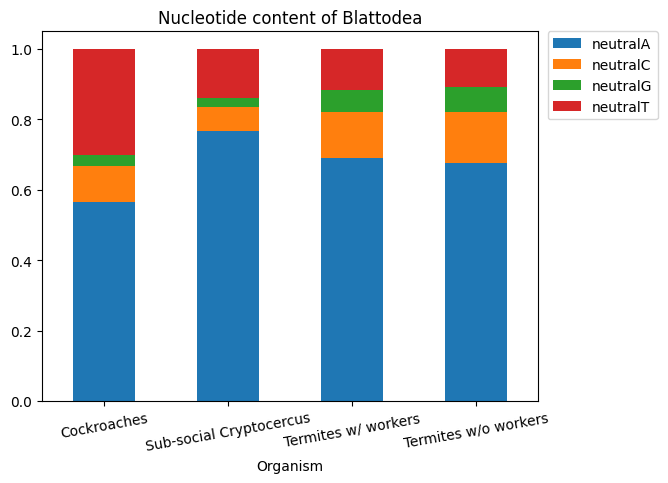

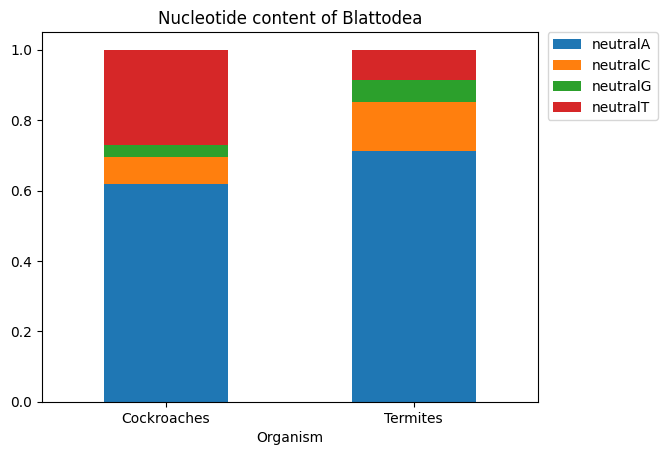

In [139]:
atgc_table = pd.concat([get_codontable(blattodea_codontable[blattodea_codontable['Workers'] == 'Cockroaches'], 'Cockroaches'), 
                        get_codontable(blattodea_codontable[blattodea_codontable['Workers'] == 'Sub-social Cryptocercus'], 'Sub-social Cryptocercus'),
                        get_codontable(blattodea_codontable[blattodea_codontable['Workers'] == 'Termites w/ workers'], 'Termites w/ workers'),
                        get_codontable(blattodea_codontable[blattodea_codontable['Workers'] == 'Termites w/o workers'], 'Termites w/o workers')])

pivoted = pd.pivot_table(atgc_table, columns=atgc_table.index, index=['Organism'])
pivoted = pivoted.drop(columns=['count'])
pivoted.columns = pivoted.columns.droplevel()

pivoted.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation = 10)
plt.title('Nucleotide content of Blattodea')

atgc_table_all = pd.concat([get_codontable(cocks_codontable, 'Cockroaches'), get_codontable(term_codontable, 'Termites')])
pivoted = pd.pivot_table(atgc_table_all, columns=atgc_table_all.index, index=['Organism'])
pivoted = pivoted.drop(columns=['count'])
pivoted.columns = pivoted.columns.droplevel()

pivoted.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation = 0)
plt.title('Nucleotide content of Blattodea')

In [140]:
mannwhitneyu(atgc_table_all[atgc_table_all['Organism'] == 'Cockroaches']['count'],atgc_table_all[atgc_table_all['Organism'] == 'Termites']['count'])

MannwhitneyuResult(statistic=5.0, pvalue=0.4857142857142857)

In [141]:
mannwhitneyu(atgc_table[atgc_table['Organism'] == 'Cockroaches']['count'],atgc_table[atgc_table['Organism'] == 'Termites w/ workers']['count'])

MannwhitneyuResult(statistic=1.0, pvalue=0.05714285714285714)

In [142]:
mannwhitneyu(atgc_table[atgc_table['Organism'] == 'Cockroaches']['count'],atgc_table[atgc_table['Organism'] == 'Termites w/o workers']['count'])

MannwhitneyuResult(statistic=4.0, pvalue=0.34285714285714286)

In [143]:
mannwhitneyu(atgc_table[atgc_table['Organism'] == 'Cockroaches']['count'],atgc_table[atgc_table['Organism'] == 'Sub-social Cryptocercus']['count'])

MannwhitneyuResult(statistic=13.0, pvalue=0.2)

In [144]:
#anova
f_oneway(atgc_table[atgc_table['Organism'] == 'Cockroaches']['count'],
         atgc_table[atgc_table['Organism'] == 'Sub-social Cryptocercus']['count'],
         atgc_table[atgc_table['Organism'] == 'Termites w/ workers']['count'],
         atgc_table[atgc_table['Organism'] == 'Termites w/o workers']['count'])

F_onewayResult(statistic=1.4715194026726448, pvalue=0.27174029366688185)

In [145]:
cocks_mutspec12 = []
for sp in cocks_meta['Species']:
    cocks_mutspec12.append(mutspec12.loc[mutspec12['Species'] == sp])
cocks_mutspec12 = pd.concat(cocks_mutspec12)

terms_mutspec12 = []
for sp in terms_meta['Species']:
    terms_mutspec12.append(mutspec12.loc[mutspec12['Species'] == sp])
terms_mutspec12 = pd.concat(terms_mutspec12)

In [146]:
terms_mutspec12

,Species,Mut,ObsNum,ExpNum,MutSpec
3816,Reticulitermes_lucifugus,A>C,2.898326,59.585554,0.047482
3817,Reticulitermes_lucifugus,A>G,3.937030,87.096946,0.044126
3818,Reticulitermes_lucifugus,A>T,0.999999,59.585554,0.016383
3819,Reticulitermes_lucifugus,C>A,3.974659,12.816840,0.302723
3823,Reticulitermes_lucifugus,C>G,0.000000,12.816840,0.000000
...,...,...,...,...,...
57477,Trinervitermes_occidentalis,G>C,0.000000,12.539586,0.000000
57478,Trinervitermes_occidentalis,G>T,0.000000,12.539586,0.000000
57476,Trinervitermes_occidentalis,T>A,0.000000,34.274300,0.000000
57471,Trinervitermes_occidentalis,T>C,10.973582,99.786313,0.421231


In [147]:
cocks_TC = cocks_mutspec12[cocks_mutspec12['Mut'] == 'T>C']
term_TC = terms_mutspec12[terms_mutspec12['Mut'] == 'T>C']
cocks_AG = cocks_mutspec12[cocks_mutspec12['Mut'] == 'A>G']
term_AG = terms_mutspec12[terms_mutspec12['Mut'] == 'A>G']

In [148]:
ttest_ind(term_TC['MutSpec'], cocks_TC['MutSpec'])

TtestResult(statistic=2.6724390779640284, pvalue=0.019175049290522037, df=13.0)

In [149]:
ttest_ind(term_AG['MutSpec'], cocks_AG['MutSpec'])

TtestResult(statistic=1.419870269604129, pvalue=0.1791799527146793, df=13.0)

In [150]:
mannwhitneyu(term_AG['MutSpec'], cocks_AG['MutSpec'])

MannwhitneyuResult(statistic=36.0, pvalue=0.3276723276723276)

In [151]:
mannwhitneyu(term_TC['MutSpec'], cocks_TC['MutSpec'])

MannwhitneyuResult(statistic=48.0, pvalue=0.011988011988011988)

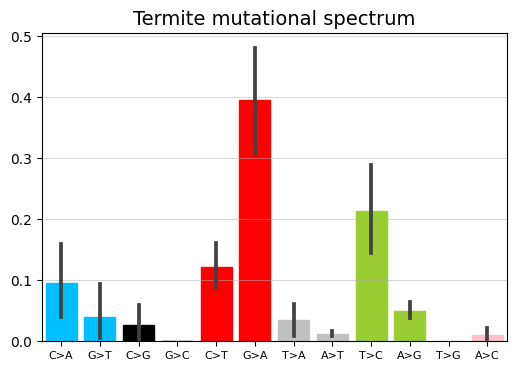

<AxesSubplot:title={'center':'Termite mutational spectrum'}>

In [152]:
draw.plot_mutspec12(terms_mutspec12, title='Termite mutational spectrum')

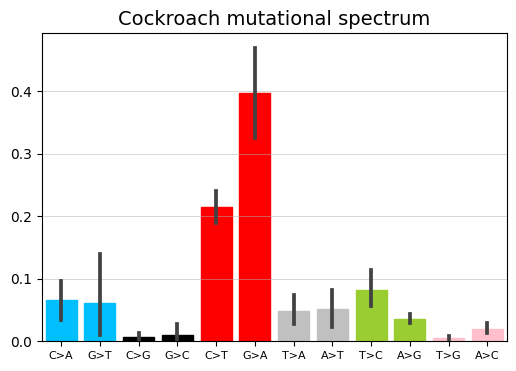

<AxesSubplot:title={'center':'Cockroach mutational spectrum'}>

In [153]:
draw.plot_mutspec12(cocks_mutspec12, title='Cockroach mutational spectrum')

# DIPTERA STUFF
  TODO: 
- ~~Add INVERTED trigger~~
- ~~Add ND1,ND4,ND4L,ND5 mondatory inversion (first check if diptera have them on negative strand, most likely it is, checks out in drosophila melanogaster)~~

In [154]:
PATH_TO_CODONTABLE = f'/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/DescriptiveStat/codontable_midori_Diptera.csv'
metadata = pd.read_csv(PATH_TO_METADATA, sep='\t', index_col=0)
diptera_meta = metadata.loc[metadata['Order'] == 'Diptera_7147']

In [155]:
nematocera_meta = [] 
families = ['Anisopodidae_52748','Bibionidae_52729','Cecidomyiidae_33406','Ceratopogonidae_41819','Chaoboridae_41811','Chironomidae_7149','Culicidae_7157','Keroplatidae_58254',
            'Limoniidae_43823','Mycetophilidae_29035','Psychodidae_7197','Ptychopteridae_79304','Sciaridae_7184','Simuliidae_7190','Tipulidae_41042']
for fam in families:
    nematocera_meta.append(diptera_meta.loc[diptera_meta['Family'] == fam])
nematocera_meta = pd.concat(nematocera_meta)
nematocera_meta.reset_index(inplace=True)

brachycera_meta = []
families = ['Agromyzidae_127399','Anthomyiidae_30062','Asilidae_50673','Aulacigastridae_286480','Calliphoridae_7371','Chamaemyiidae_189958','Chloropidae_29032',
            'Clusiidae_286472','Conopidae_115263','Dolichopodidae_92558','Drosophilidae_7214','Dryomyzidae_169441','Empididae_92557','Ephydridae_48991',
            'Fanniidae_27471','Fergusoninidae_156410','Glossinidae_7392','Heleomyzidae_219548','Hippoboscidae_81710','Hybotidae_1446258','Lauxaniidae_189929',
            'Milichiidae_305559','Muscidae_7366','Mydidae_50677','Nemestrinidae_92615','Nycteribiidae_81707','Oestridae_7387','Opomyzidae_286476','Phoridae_36164',
            'Piophilidae_28629','Pipunculidae_43835','Platypezidae_43827','Platystomatidae_28632','Polleniidae_54279','Rhagionidae_92609','Sarcophagidae_7381',
            'Scathophagidae_43756','Sciomyzidae_169447','Sepsidae_137503','Sphaeroceridae_114620','Stratiomyidae_34687','Streblidae_81697','Syrphidae_34680',
            'Tachinidae_27474','Tephritidae_7211','Tabanidae_7205','Xylophagaidae_92613']
for fam in families:
    brachycera_meta.append(diptera_meta.loc[diptera_meta['Family'] == fam])
brachycera_meta = pd.concat(brachycera_meta)
brachycera_meta.reset_index(inplace=True)


In [156]:
diptera_codontable = pd.read_csv(PATH_TO_CODONTABLE, index_col=0)
diptera_codontable['Species_name'] = list(map(lambda sp: f'{sp.split("_")[0]}_{sp.split("_")[1]}', diptera_codontable['Species_name']))

nematocera_codontable = []
for sp in nematocera_meta['Species']:
    nematocera_codontable.append(diptera_codontable.loc[diptera_codontable['Species_name'] == sp])
nematocera_codontable = pd.concat(nematocera_codontable)

brachycera_codontable = []
for sp in brachycera_meta['Species']:
    brachycera_codontable.append(diptera_codontable.loc[diptera_codontable['Species_name'] == sp])
brachycera_codontable = pd.concat(brachycera_codontable)

In [157]:
if INVERT == True:
    def get_codontable(codontable, organism):
        #summing for genes on negative strand
        neg_codontable = codontable.loc[(codontable['Gene_name'] == 'ND1') | (codontable['Gene_name'] == 'ND4') | (codontable['Gene_name'] == 'ND4L') | (codontable['Gene_name'] == 'ND5')]
        codontable = codontable.drop(codontable[(codontable['Gene_name'] == 'ND1') | (codontable['Gene_name'] == 'ND4') | (codontable['Gene_name'] == 'ND4L') | (codontable['Gene_name'] == 'ND5')].index)
        neg_atgc = neg_codontable.agg({'neutralA' : 'sum', 'neutralT' : 'sum', 'neutralG' : 'sum', 'neutralC' : 'sum'}).to_frame(name='count')

        #summing for genes on positive strand
        codontable = codontable.rename(columns={'neutralA' : 'neutralT', 'neutralT' : 'neutralA', 'neutralG' : 'neutralC', 'neutralC' : 'neutralG'})
        atgc_table = codontable.agg({'neutralA' : 'sum', 'neutralT' : 'sum', 'neutralG' : 'sum', 'neutralC' : 'sum'}).to_frame(name='count')
        atgc_table['count'] = atgc_table['count'] + neg_atgc['count']


        atgc_table['Organism'] = organism
        atgc_table['normalized_count'] = np.nan
        atgc_table.at['neutralA', 'normalized_count'] = atgc_table.at['neutralA', 'count'] / atgc_table['count'].sum()
        atgc_table.at['neutralT', 'normalized_count'] = atgc_table.at['neutralT', 'count'] / atgc_table['count'].sum()
        atgc_table.at['neutralG', 'normalized_count'] = atgc_table.at['neutralG', 'count'] / atgc_table['count'].sum()
        atgc_table.at['neutralC', 'normalized_count'] = atgc_table.at['neutralC', 'count'] / atgc_table['count'].sum()

        return atgc_table
else:
    def get_codontable(codontable, organism):
        #summing for genes on negative strand
        neg_codontable = codontable.rename(columns={'neutralA' : 'neutralT', 'neutralT' : 'neutralA', 'neutralG' : 'neutralC', 'neutralC' : 'neutralG'})
        codontable = codontable.drop(codontable[(codontable['Gene_name'] == 'ND1') | (codontable['Gene_name'] == 'ND4') | (codontable['Gene_name'] == 'ND4L') | (codontable['Gene_name'] == 'ND5')].index)
        neg_atgc = neg_codontable.agg({'neutralA' : 'sum', 'neutralT' : 'sum', 'neutralG' : 'sum', 'neutralC' : 'sum'}).to_frame(name='count')

        #summing for genes on positive strand
        atgc_table = codontable.agg({'neutralA' : 'sum', 'neutralT' : 'sum', 'neutralG' : 'sum', 'neutralC' : 'sum'}).to_frame(name='count')
        atgc_table['count'] = atgc_table['count']# + neg_atgc['count']


        atgc_table['Organism'] = organism
        atgc_table['normalized_count'] = np.nan
        atgc_table.at['neutralA', 'normalized_count'] = atgc_table.at['neutralA', 'count'] / atgc_table['count'].sum()
        atgc_table.at['neutralT', 'normalized_count'] = atgc_table.at['neutralT', 'count'] / atgc_table['count'].sum()
        atgc_table.at['neutralG', 'normalized_count'] = atgc_table.at['neutralG', 'count'] / atgc_table['count'].sum()
        atgc_table.at['neutralC', 'normalized_count'] = atgc_table.at['neutralC', 'count'] / atgc_table['count'].sum()

        return atgc_table

Text(0.5, 1.0, 'Nucleotide content of Diptera')

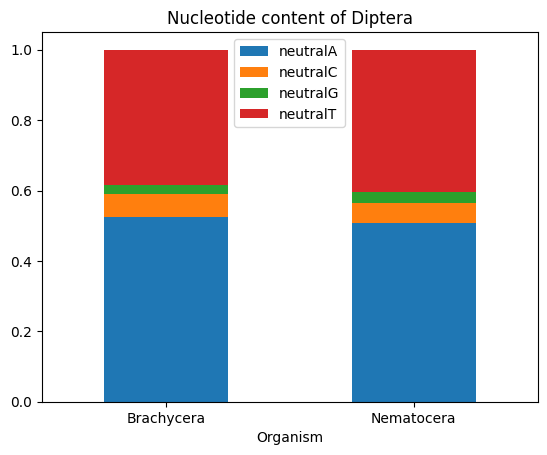

In [158]:
atgc_table = pd.concat([get_codontable(nematocera_codontable, 'Nematocera'), get_codontable(brachycera_codontable, 'Brachycera')])

pivoted = pd.pivot_table(atgc_table, columns=atgc_table.index, index=['Organism'])
pivoted = pivoted.drop(columns=['count'])
pivoted.columns = pivoted.columns.droplevel()

pivoted.plot(kind='bar', stacked=True)
plt.legend(loc='upper center')
plt.xticks(rotation = 0)
plt.title('Nucleotide content of Diptera')

In [159]:
nematocera_mutspec12 = []
for sp in nematocera_meta['Species']:
    nematocera_mutspec12.append(mutspec12.loc[mutspec12['Species'] == sp])
nematocera_mutspec12 = pd.concat(nematocera_mutspec12)

brachycera_mutspec12 = []
for sp in brachycera_meta['Species']:
    brachycera_mutspec12.append(mutspec12.loc[mutspec12['Species'] == sp])
brachycera_mutspec12 = pd.concat(brachycera_mutspec12)

In [160]:
nematocera_TC = nematocera_mutspec12[nematocera_mutspec12['Mut'] == 'T>C']
brachycera_TC = brachycera_mutspec12[brachycera_mutspec12['Mut'] == 'T>C']
nematocera_AG = nematocera_mutspec12[nematocera_mutspec12['Mut'] == 'A>G']
brachycera_AG = brachycera_mutspec12[brachycera_mutspec12['Mut'] == 'A>G']

In [161]:
mannwhitneyu(nematocera_AG['MutSpec'], brachycera_AG['MutSpec'])

MannwhitneyuResult(statistic=226119.0, pvalue=3.222981086416654e-08)

In [162]:
mannwhitneyu(nematocera_TC['MutSpec'], brachycera_TC['MutSpec'])

MannwhitneyuResult(statistic=169468.0, pvalue=0.0007294524155448768)

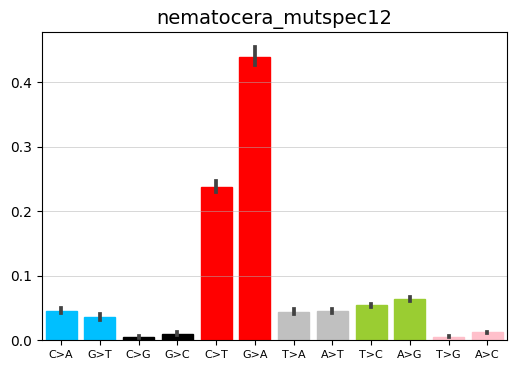

<AxesSubplot:title={'center':'nematocera_mutspec12'}>

In [163]:
draw.plot_mutspec12(nematocera_mutspec12, title='nematocera_mutspec12')

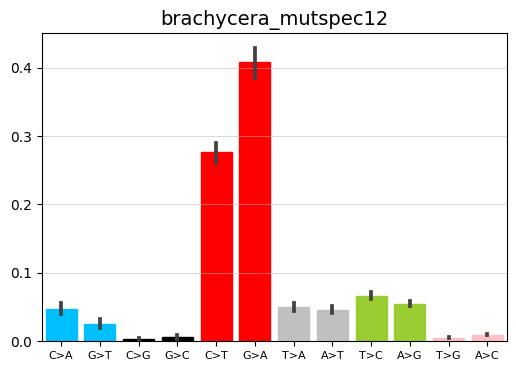

<AxesSubplot:title={'center':'brachycera_mutspec12'}>

In [164]:
draw.plot_mutspec12(brachycera_mutspec12, title='brachycera_mutspec12')

# Syrphidae stuff (family in Diptera) 

In [165]:
PATH_TO_CODONTABLE = f'/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/DescriptiveStat/codontable_midori_Diptera.csv'
metadata = pd.read_csv(PATH_TO_METADATA, sep='\t', index_col=0)
syrphidae_meta = metadata.loc[metadata['Family'] == 'Syrphidae_34680']

predator_syrph = []
predator_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Syrphus_224255'])
predator_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Scaeva_219538'])
predator_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Sphaerophoria_226179'])
predator_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Melanostoma_92597'])
predator_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Platycheirus_192444'])
predator_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Paragus_115308'])
predator_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Pipiza_221788'])
predator_syrph = pd.concat(predator_syrph)
predator_syrph.reset_index(inplace=True)

detritophagus_syrph = []
detritophagus_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Eristalis_198633'])
detritophagus_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Myathropa_2714348'])
detritophagus_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Helophilus_226173'])
detritophagus_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Chrysogaster_224248'])
detritophagus_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Sphegina_226166'])
detritophagus_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Neoascia_224222'])
detritophagus_syrph = pd.concat(detritophagus_syrph)
detritophagus_syrph.reset_index(inplace=True)

phytophagus_syrph = []
phytophagus_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Cheilosia_173981'])
phytophagus_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Eumerus_224220'])
phytophagus_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Merodon_224226'])
phytophagus_syrph = pd.concat(phytophagus_syrph)
phytophagus_syrph.reset_index(inplace=True)

xylobiont_syrph = []
xylobiont_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Mallota_535942'])
xylobiont_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Blera_226146'])
xylobiont_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Criorhina_224238'])
xylobiont_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Xylota_224240'])
xylobiont_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Spilomyia_226162'])
xylobiont_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Temnostoma_226164'])
xylobiont_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Brachyopa_1637464'])
xylobiont_syrph = pd.concat(xylobiont_syrph)
xylobiont_syrph.reset_index(inplace=True)

'''
#NONE OF THESE ARE PRESENT IN msMetaData
inquilin_syrph =[]
inquilin_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Volucella_226148'])
inquilin_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Microdon_115291'])
inquilin_syrph = pd.concat(inquilin_syrph)
inquilin_syrph.reset_index(inplace=True)
'''

coprobiont_syrph = []
coprobiont_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Syritta_34681'])
coprobiont_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Rhingia_192449'])
coprobiont_syrph = pd.concat(coprobiont_syrph)
coprobiont_syrph.reset_index(inplace=True)

In [166]:
diptera_codontable = pd.read_csv(PATH_TO_CODONTABLE, index_col=0)
diptera_codontable['Species_name'] = list(map(lambda sp: f'{sp.split("_")[0]}_{sp.split("_")[1]}', diptera_codontable['Species_name']))

predator_syrph_codontable = []
for sp in predator_syrph['Species']:
    predator_syrph_codontable.append(diptera_codontable.loc[diptera_codontable['Species_name'] == sp])
predator_syrph_codontable = pd.concat(predator_syrph_codontable)

detritophagus_syrph_codontable = []
for sp in detritophagus_syrph['Species']:
    detritophagus_syrph_codontable.append(diptera_codontable.loc[diptera_codontable['Species_name'] == sp])
detritophagus_syrph_codontable = pd.concat(detritophagus_syrph_codontable)

"""
#NONE IN CODONTABLE
phytophagus_syrph_codontable = []
for sp in phytophagus_syrph['Species']:
    phytophagus_syrph_codontable.append(diptera_codontable.loc[diptera_codontable['Species_name'] == sp])
phytophagus_syrph_codontable = pd.concat(phytophagus_syrph_codontable)
"""

"""
#NONE IN CODONTABLE
xylobiont_syrph_codontable = []
for sp in xylobiont_syrph['Species']:
    xylobiont_syrph_codontable.append(diptera_codontable.loc[diptera_codontable['Species_name'] == sp])
xylobiont_syrph_codontable = pd.concat(xylobiont_syrph_codontable)
"""

coprobiont_syrph_codontable = []
for sp in coprobiont_syrph['Species']:
    coprobiont_syrph_codontable.append(diptera_codontable.loc[diptera_codontable['Species_name'] == sp])
coprobiont_syrph_codontable = pd.concat(coprobiont_syrph_codontable)

Text(0.5, 1.0, 'Nucleotide content of Syrphidae')

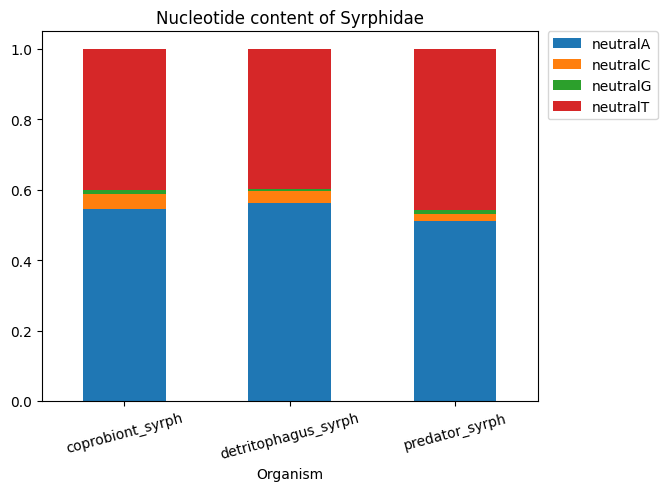

In [167]:
#get codon table is in DIPTERA STUFF

atgc_table = pd.concat([get_codontable(predator_syrph_codontable, 'predator_syrph'), get_codontable(detritophagus_syrph_codontable, 'detritophagus_syrph'), 
                        get_codontable(coprobiont_syrph_codontable, 'coprobiont_syrph')])

pivoted = pd.pivot_table(atgc_table, columns=atgc_table.index, index=['Organism'])
pivoted = pivoted.drop(columns=['count'])
pivoted.columns = pivoted.columns.droplevel()

pivoted.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation = 15)
plt.title('Nucleotide content of Syrphidae')

In [168]:
predator_syrph_mutspec12 = []
for sp in predator_syrph['Species']:
    predator_syrph_mutspec12.append(mutspec12.loc[mutspec12['Species'] == sp])
predator_syrph_mutspec12 = pd.concat(predator_syrph_mutspec12)

detritophagus_syrph_mutspec12 = []
for sp in detritophagus_syrph['Species']:
    detritophagus_syrph_mutspec12.append(mutspec12.loc[mutspec12['Species'] == sp])
detritophagus_syrph_mutspec12 = pd.concat(detritophagus_syrph_mutspec12)

phytophagus_syrph_mutspec12 = []
for sp in phytophagus_syrph['Species']:
    phytophagus_syrph_mutspec12.append(mutspec12.loc[mutspec12['Species'] == sp])
phytophagus_syrph_mutspec12 = pd.concat(phytophagus_syrph_mutspec12)

xylobiont_syrph_mutspec12 = []
for sp in xylobiont_syrph['Species']:
    xylobiont_syrph_mutspec12.append(mutspec12.loc[mutspec12['Species'] == sp])
xylobiont_syrph_mutspec12 = pd.concat(xylobiont_syrph_mutspec12)

coprobiont_syrph_mutspec12 = []
for sp in coprobiont_syrph['Species']:
    coprobiont_syrph_mutspec12.append(mutspec12.loc[mutspec12['Species'] == sp])
coprobiont_syrph_mutspec12 = pd.concat(coprobiont_syrph_mutspec12)

In [169]:
predator_syrph_AG = predator_syrph_mutspec12[predator_syrph_mutspec12['Mut'] == 'A>G']
detritophagus_syrph_AG = detritophagus_syrph_mutspec12[detritophagus_syrph_mutspec12['Mut'] == 'A>G']
phytophagus_syrph_AG = phytophagus_syrph_mutspec12[phytophagus_syrph_mutspec12['Mut'] == 'A>G']
xylobiont_syrph_AG = xylobiont_syrph_mutspec12[xylobiont_syrph_mutspec12['Mut'] == 'A>G']
coprobiont_syrph_AG = coprobiont_syrph_mutspec12[coprobiont_syrph_mutspec12['Mut'] == 'A>G']

In [170]:
f_oneway(predator_syrph_AG['MutSpec'], detritophagus_syrph_AG['MutSpec'], phytophagus_syrph_AG['MutSpec'], xylobiont_syrph_AG['MutSpec'], coprobiont_syrph_AG['MutSpec'])

F_onewayResult(statistic=0.5113717036734392, pvalue=0.7277359156730878)

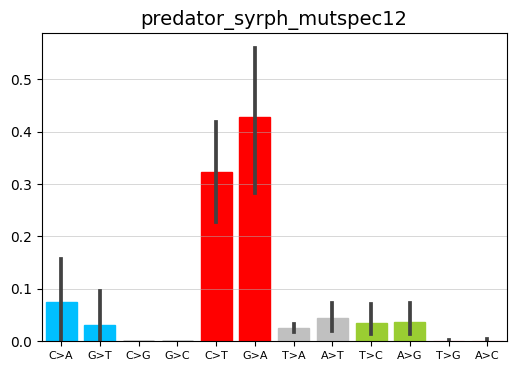

<AxesSubplot:title={'center':'predator_syrph_mutspec12'}>

In [171]:

draw.plot_mutspec12(predator_syrph_mutspec12, title='predator_syrph_mutspec12')


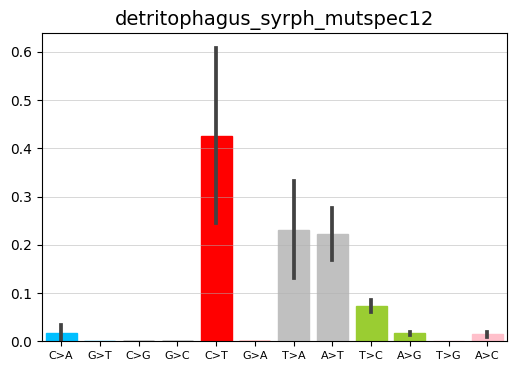

<AxesSubplot:title={'center':'detritophagus_syrph_mutspec12'}>

In [172]:
draw.plot_mutspec12(detritophagus_syrph_mutspec12, title='detritophagus_syrph_mutspec12')

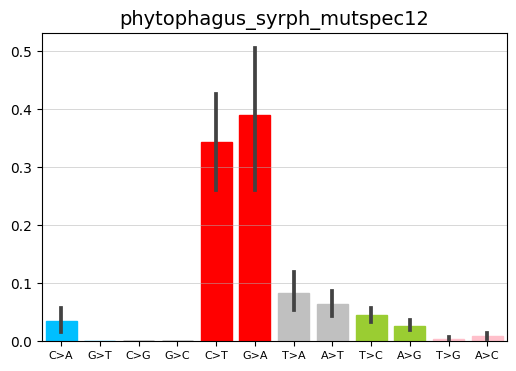

<AxesSubplot:title={'center':'phytophagus_syrph_mutspec12'}>

In [173]:
draw.plot_mutspec12(phytophagus_syrph_mutspec12, title='phytophagus_syrph_mutspec12')

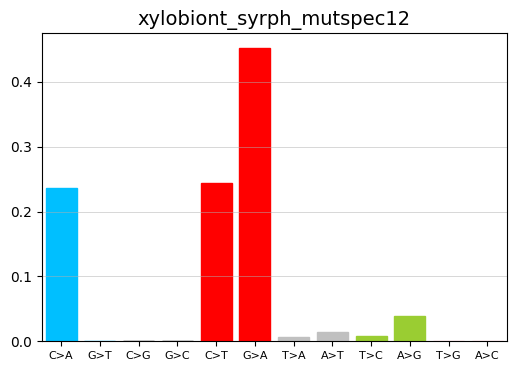

<AxesSubplot:title={'center':'xylobiont_syrph_mutspec12'}>

In [174]:
draw.plot_mutspec12(xylobiont_syrph_mutspec12, title='xylobiont_syrph_mutspec12')

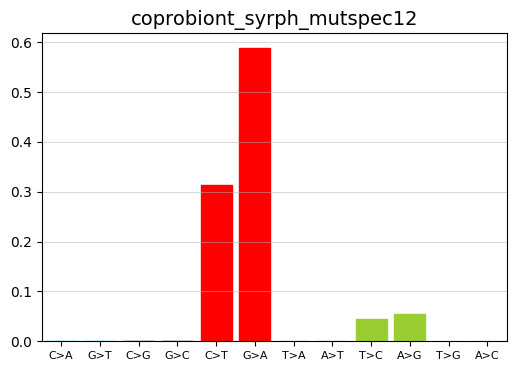

<AxesSubplot:title={'center':'coprobiont_syrph_mutspec12'}>

In [175]:
draw.plot_mutspec12(coprobiont_syrph_mutspec12, title='coprobiont_syrph_mutspec12')

# Hymenoptera stuff
TODO:
- Add INVERTED trigger

In [176]:
PATH_TO_CODONTABLE = f'/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/DescriptiveStat/codontable_midori_Hymenoptera.csv'
metadata = pd.read_csv(PATH_TO_METADATA, sep='\t', index_col=0)
Hymenoptera_meta = metadata.loc[metadata['Order'] == 'Hymenoptera_7399']

In [177]:
# WIP, separate hymenoptera families
terms_meta = [] 
terms_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Rhinotermitidae_36985'])
terms_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Termitidae_46569'])
terms_meta = pd.concat(terms_meta)
terms_meta.reset_index(inplace=True)

cocks_meta = []
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Blattidae_6974'])
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Cryptocercidae_36982'])
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Ectobiidae_1049651'])
cocks_meta = pd.concat(cocks_meta)
cocks_meta.reset_index(inplace=True)

In [178]:
hymenoptera_codontable = pd.read_csv(PATH_TO_CODONTABLE, index_col=0)
hymenoptera_codontable['Species_name'] = list(map(lambda sp: f'{sp.split("_")[0]}_{sp.split("_")[1]}', diptera_codontable['Species_name']))

# WIP, separate hymenoptera families
term_codontable = []
for sp in terms_meta['Species']:
    term_codontable.append(blattodea_codontable.loc[blattodea_codontable['Species_name'] == sp])
term_codontable = pd.concat(term_codontable)

cocks_codontable = []
for sp in cocks_meta['Species']:
    cocks_codontable.append(blattodea_codontable.loc[blattodea_codontable['Species_name'] == sp])
cocks_codontable = pd.concat(cocks_codontable)

ValueError: Length of values (12922) does not match length of index (3406)

Text(0.5, 1.0, 'Nucleotide content of Blattodea')

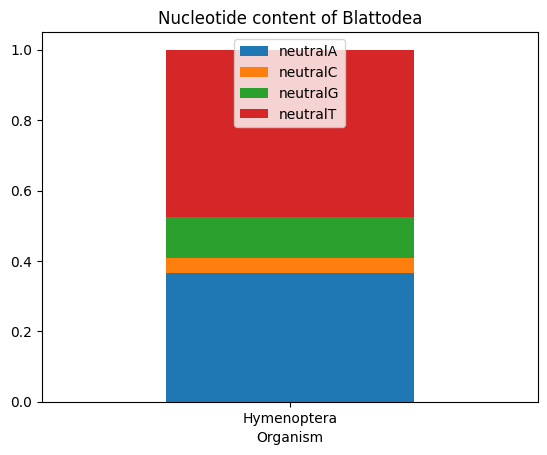

In [ ]:
#!!!! NUCL VALUES ARE INVERTED FOR NOW
def get_codontable(codontable, organism):
    codontable = codontable.rename(columns={'neutralA' : 'neutralT', 'neutralT' : 'neutralA', 'neutralG' : 'neutralC', 'neutralC' : 'neutralG'})
    atgc_table = codontable.agg({'neutralA' : 'sum', 'neutralT' : 'sum', 'neutralG' : 'sum', 'neutralC' : 'sum'}).to_frame(name='count')
    atgc_table['Organism'] = organism
    atgc_table['normalized_count'] = np.nan
    atgc_table.at['neutralA', 'normalized_count'] = atgc_table.at['neutralA', 'count'] / atgc_table['count'].sum()
    atgc_table.at['neutralT', 'normalized_count'] = atgc_table.at['neutralT', 'count'] / atgc_table['count'].sum()
    atgc_table.at['neutralG', 'normalized_count'] = atgc_table.at['neutralG', 'count'] / atgc_table['count'].sum()
    atgc_table.at['neutralC', 'normalized_count'] = atgc_table.at['neutralC', 'count'] / atgc_table['count'].sum()
    return atgc_table

atgc_table = get_codontable(hymenoptera_codontable, 'Hymenoptera')

pivoted = pd.pivot_table(atgc_table, columns=atgc_table.index, index=['Organism'])
pivoted = pivoted.drop(columns=['count'])
pivoted.columns = pivoted.columns.droplevel()

pivoted.plot(kind='bar', stacked=True)
plt.legend(loc='upper center')
plt.xticks(rotation = 0)
plt.title('Nucleotide content of Blattodea')